Here, we want to know the model with the best explanatory power, compared to the rest.

## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install python ipykernel
pip install watermark bambi xarray netcdf4 seaborn
# pip install bokeh
```

In [1]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt

WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
results = xr.open_dataset('models/connectivities_classifier-SVML1_measure-accuracy_top-6_cv-100x4fold.nc').load()

split_score_cols = [c for c in list(results.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = results[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)
scores['label'] = scores['label'].apply(lambda x: x.replace('partial correlation', 'partial_correlation'))

scores[['atlas','kind']] = scores['label'].apply(lambda x: x.split(' ')).apply(pd.Series)
scores = scores[['atlas', 'kind', 'test_score']]

In [3]:
model = bambi.Model('test_score ~ 0 + atlas * kind', scores)
fitted = model.fit(tune=100, draws=100, init='adapt_diag')

az.summary(fitted).sort_values('mean', ascending=False)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atlas, kind, atlas:kind, test_score_sigma]
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degrad

/usr/local/Caskroom/miniforge/base/envs/acnets_bambi/lib/python3.10/site-packages/aesara/tensor/elemwise.py:769: RuntimeWarning: overflow encountered in square
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/Caskroom/miniforge/base/envs/acnets_bambi/lib/python3.10/site-packages/aesara/tensor/elemwise.py:769: RuntimeWarning: overflow encountered in square
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/Caskroom/miniforge/base/envs/acnets_bambi/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/Caskroom/miniforge/base/envs/acnets_bambi/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/Caskroom/miniforge/base/envs/acnets_bambi/lib/python3.10/site-packages/aesara/scalar/basic.py:1994: RuntimeWarning: invalid value encou

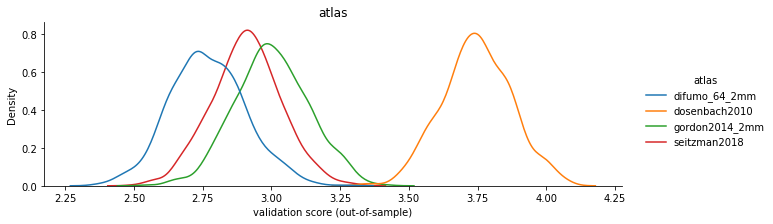

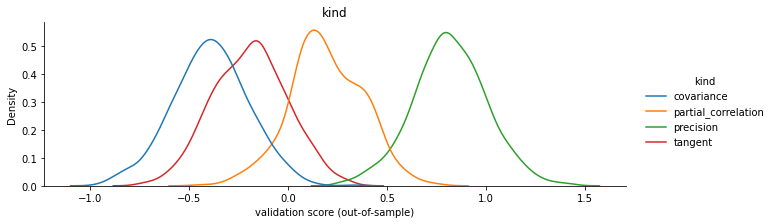

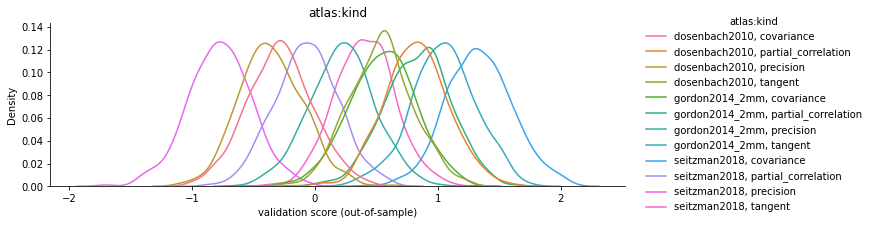

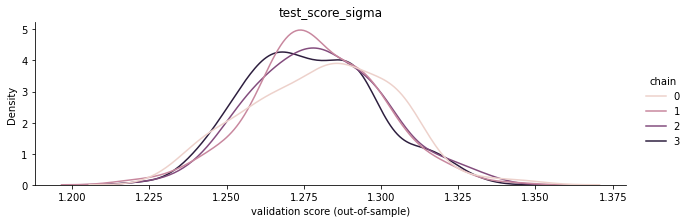

In [161]:
fitted['posterior']['atlas']

import seaborn as sns

for i, var_name in enumerate(fitted['posterior'].data_vars):
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name else 2
    g = sns.displot(data=plot_data,
                    x=var_name,
                    kind='kde',
                    aspect=3,
                    height=3,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    # height=2, aspect=2,
                    )
    g.set(xlabel='validation score (out-of-sample)')
    g.set(title=var_name)
    g.legend.set_title(g.legend.get_title().get_text().replace('_dim',''))

    plt.show()


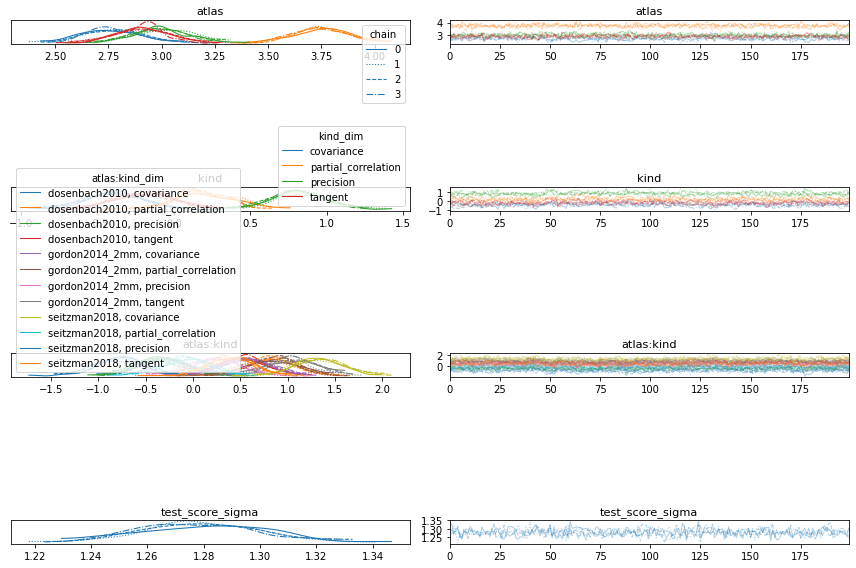

In [5]:
# DEBUG use arviz to plot the posteriors and traces
# az.plot_trace(fitted, legend=True)
# plt.show()

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jul 24 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

re        : 2.2.1
bambi     : 0.9.0
xarray    : 2022.3.0
pandas    : 1.4.3
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:09:13) [Clang 13.0.1 ]
matplotlib: 3.5.2
arviz     : 0.12.1
seaborn   : 0.11.2

Watermark: 2.3.1

